In [1]:
import networkx as nx
from networkx.algorithms import approximation
import cugraph
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm

import gc
import pathlib

In [2]:
%run ../wmis_gnn_py/util/metis.py

In [3]:
??metis_to_nx

Signature: metis_to_nx(filename: str)
Docstring: <no docstring>
Source:   
def metis_to_nx(filename: str):
    G = nx.Graph()

    with open(filename, "r") as f:
        for line_num, line in enumerate(f):
            if line_num == 0:
                n_vertices, n_edges, graph_type = map(int, line.split(" "))

                assert n_vertices >= 0
                assert n_edges >= 0
                assert graph_type == 10

                continue

            if line[0] == "%":
                continue

            node_weight, *neighbors = map(int, line.split(" "))

            assert node_weight > 0

            G.add_node(line_num, weight=node_weight)

            for v in neighbors:
                assert 1 <= v <= n_vertices
                G.add_edge(line_num, v)

        assert G.size() == n_edges

    return G
File:      /gpfs/gibbs/project/karbasi/cz397/CPSC583-Project/wmis_gnn_py/util/metis.py
Type:      function


In [10]:
def summarize_graph(G: nx.Graph, name: str):
    n_nodes = G.order()
    n_edges = G.size()
    avg_deg = 2 * n_edges / n_nodes
    n_components = nx.number_connected_components(G)
    n_isolates = nx.number_of_isolates(G)
    sum_weights = sum(G.nodes[v]["weight"] for v in range(1, G.order() + 1))
    # transitivity = nx.transitivity(G)
    # degree_assortativity_coefficient = nx.degree_assortativity_coefficient(G)
    # estrada_index = nx.estrada_index(G)
    # treewidth_min_fill_in, _ = approximation.treewidth_min_fill_in(G)
    treewidth_min_degree, _ = approximation.treewidth_min_degree(G)
    # treewidth_approx = min(treewidth_min_fill_in, treewidth_min_degree)
    # s_metric = cugraph.s_metric(G, normalized=True)
    average_clustering = approximation.average_clustering(G)

    # is_chordal = nx.is_chordal(G)
    # is_planar = nx.is_planar(G)
    # is_eulerian = nx.is_eulerian(G)
    # is_regular = nx.is_regular(G)

    return {
        "name": name,
        "n_nodes": n_nodes,
        "n_edges": n_edges,
        "avg_deg": avg_deg,
        "n_components": n_components,
        "n_isolates": n_isolates,
        "sum_weights": sum_weights,
        # "transitivity": transitivity,
        # "degree_assortativity_coefficient": degree_assortativity_coefficient,
        # "estrada_index": estrada_index,
        "treewidth_min_degree": treewidth_min_degree,
        # "treewidth_approx": treewidth_approx,
        "average_clustering": average_clustering,
        # "s_metric": s_metric,
        # "is_planar": is_planar,
        # "is_chordal": is_chordal,
        # "is_eulerian": is_eulerian,
        # "is_regular": is_regular,
    }

# Small Erdos-Reyni Graphs

In [65]:
rows = []

ind_base = pathlib.Path("../data/erdos_reyni_small/label/")

graph_paths = np.random.choice(
    list(yield_metis_filenames("../data/erdos_reyni_small/")), 200, replace=False
)
ind_paths = set(path.stem for path in yield_solution_filenames(ind_base.resolve()))
for graph_path in tqdm(graph_paths):
    G = metis_to_nx(graph_path.resolve())
    summary_dict = summarize_graph(G, graph_path.stem)
    summary_dict["kamis_weight"] = -np.inf

    if graph_path.stem in ind_paths:
        ind_path = ind_base / graph_path.with_suffix(".ind").name
        solution_to_nx(G, ind_path.resolve())
        solution_weight = sum(
            G.nodes[v]["weight"]
            for v in range(1, G.order() + 1)
            if G.nodes[v]["solution"] == 1
        )
        summary_dict["kamis_weight"] = solution_weight

    rows.append(pd.Series(summary_dict))

    gc.collect()

df_er = pd.DataFrame(rows).set_index("name")
df_er

100%|██████████| 200/200 [03:15<00:00,  1.02it/s]


,n_nodes,n_edges,avg_deg,n_components,n_isolates,sum_weights,treewidth_min_degree,average_clustering,kamis_weight
name,,,,,,,,,
erdos-reyni-n200-p0.1--maxw400-seed20_681,200,1983,19.83,1,0,40965,134,0.093,10582
erdos-reyni-n200-p0.1--maxw400-seed20_259,200,2076,20.76,1,0,40134,137,0.112,9574
erdos-reyni-n200-p0.1--maxw400-seed20_535,200,2029,20.29,1,0,41677,136,0.108,10665
erdos-reyni-n200-p0.1--maxw400-seed20_764,200,2038,20.38,1,0,41382,136,0.099,10276
erdos-reyni-n200-p0.1--maxw400-seed20_332,200,1975,19.75,1,0,38274,133,0.098,10204
...,...,...,...,...,...,...,...,...,...
erdos-reyni-n200-p0.1--maxw400-seed20_171,200,2046,20.46,1,0,39624,135,0.102,10387
erdos-reyni-n200-p0.1--maxw400-seed20_513,200,1969,19.69,1,0,41324,135,0.085,10323
erdos-reyni-n200-p0.1--maxw400-seed20_379,200,2033,20.33,1,0,40261,138,0.082,9884


In [66]:
df_er.to_csv("erdos_reyni_small.csv")

In [2]:
def plot_graph_df(df):
    fig, axes = plt.subplots(3, 2, figsize=(12, 12), dpi=200)
    # fig.suptitle("PACE Graph Statistics", fontsize="xx-large")
    fig.tight_layout(h_pad=5, w_pad=0)

    axes[0, 0].ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    axes[0, 0].set_xlabel("Number of Vertices", fontsize="large")
    axes[0, 0].set_title("Histogram of Number of Vertices", fontsize="x-large")
    df.n_nodes.hist(bins=50, log=True, ax=axes[0, 0])

    axes[0, 1].ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    axes[0, 1].set_xlabel("Number of Edges", fontsize="large")
    axes[0, 1].set_title("Histogram of Number of Edges", fontsize="x-large")
    df.n_edges.hist(bins=50, log=True, ax=axes[0, 1])

    # axes[0, 2].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    axes[1, 0].set_xlabel("Average Degree", fontsize="large")
    axes[1, 0].set_title("Histogram of Average Degree", fontsize="x-large")
    df.avg_deg.hist(bins=50, log=True, ax=axes[1, 0])

    axes[1, 1].ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    axes[1, 1].set_xlabel("Number of Connected Components", fontsize="large")
    axes[1, 1].set_title(
        "Histogram of Number of Connected Components", fontsize="x-large"
    )
    df.n_components.hist(bins=50, log=True, ax=axes[1, 1])

    # axes[1, 1].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    axes[2, 0].set_xlabel("Treewidth Upperbound", fontsize="large")
    axes[2, 0].set_title("Histogram of Treewidth Upperbound", fontsize="x-large")
    df.treewidth_min_degree.hist(bins=50, log=True, ax=axes[2, 0])

    # axes[1, 2].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    axes[2, 1].set_xlabel(
        "Approximate Average Clustering Coefficient", fontsize="large"
    )
    axes[2, 1].set_title(
        "Histogram of Approximate Average Clustering Coefficient", fontsize="x-large"
    )
    df.average_clustering.hist(bins=50, log=True, ax=axes[2, 1])

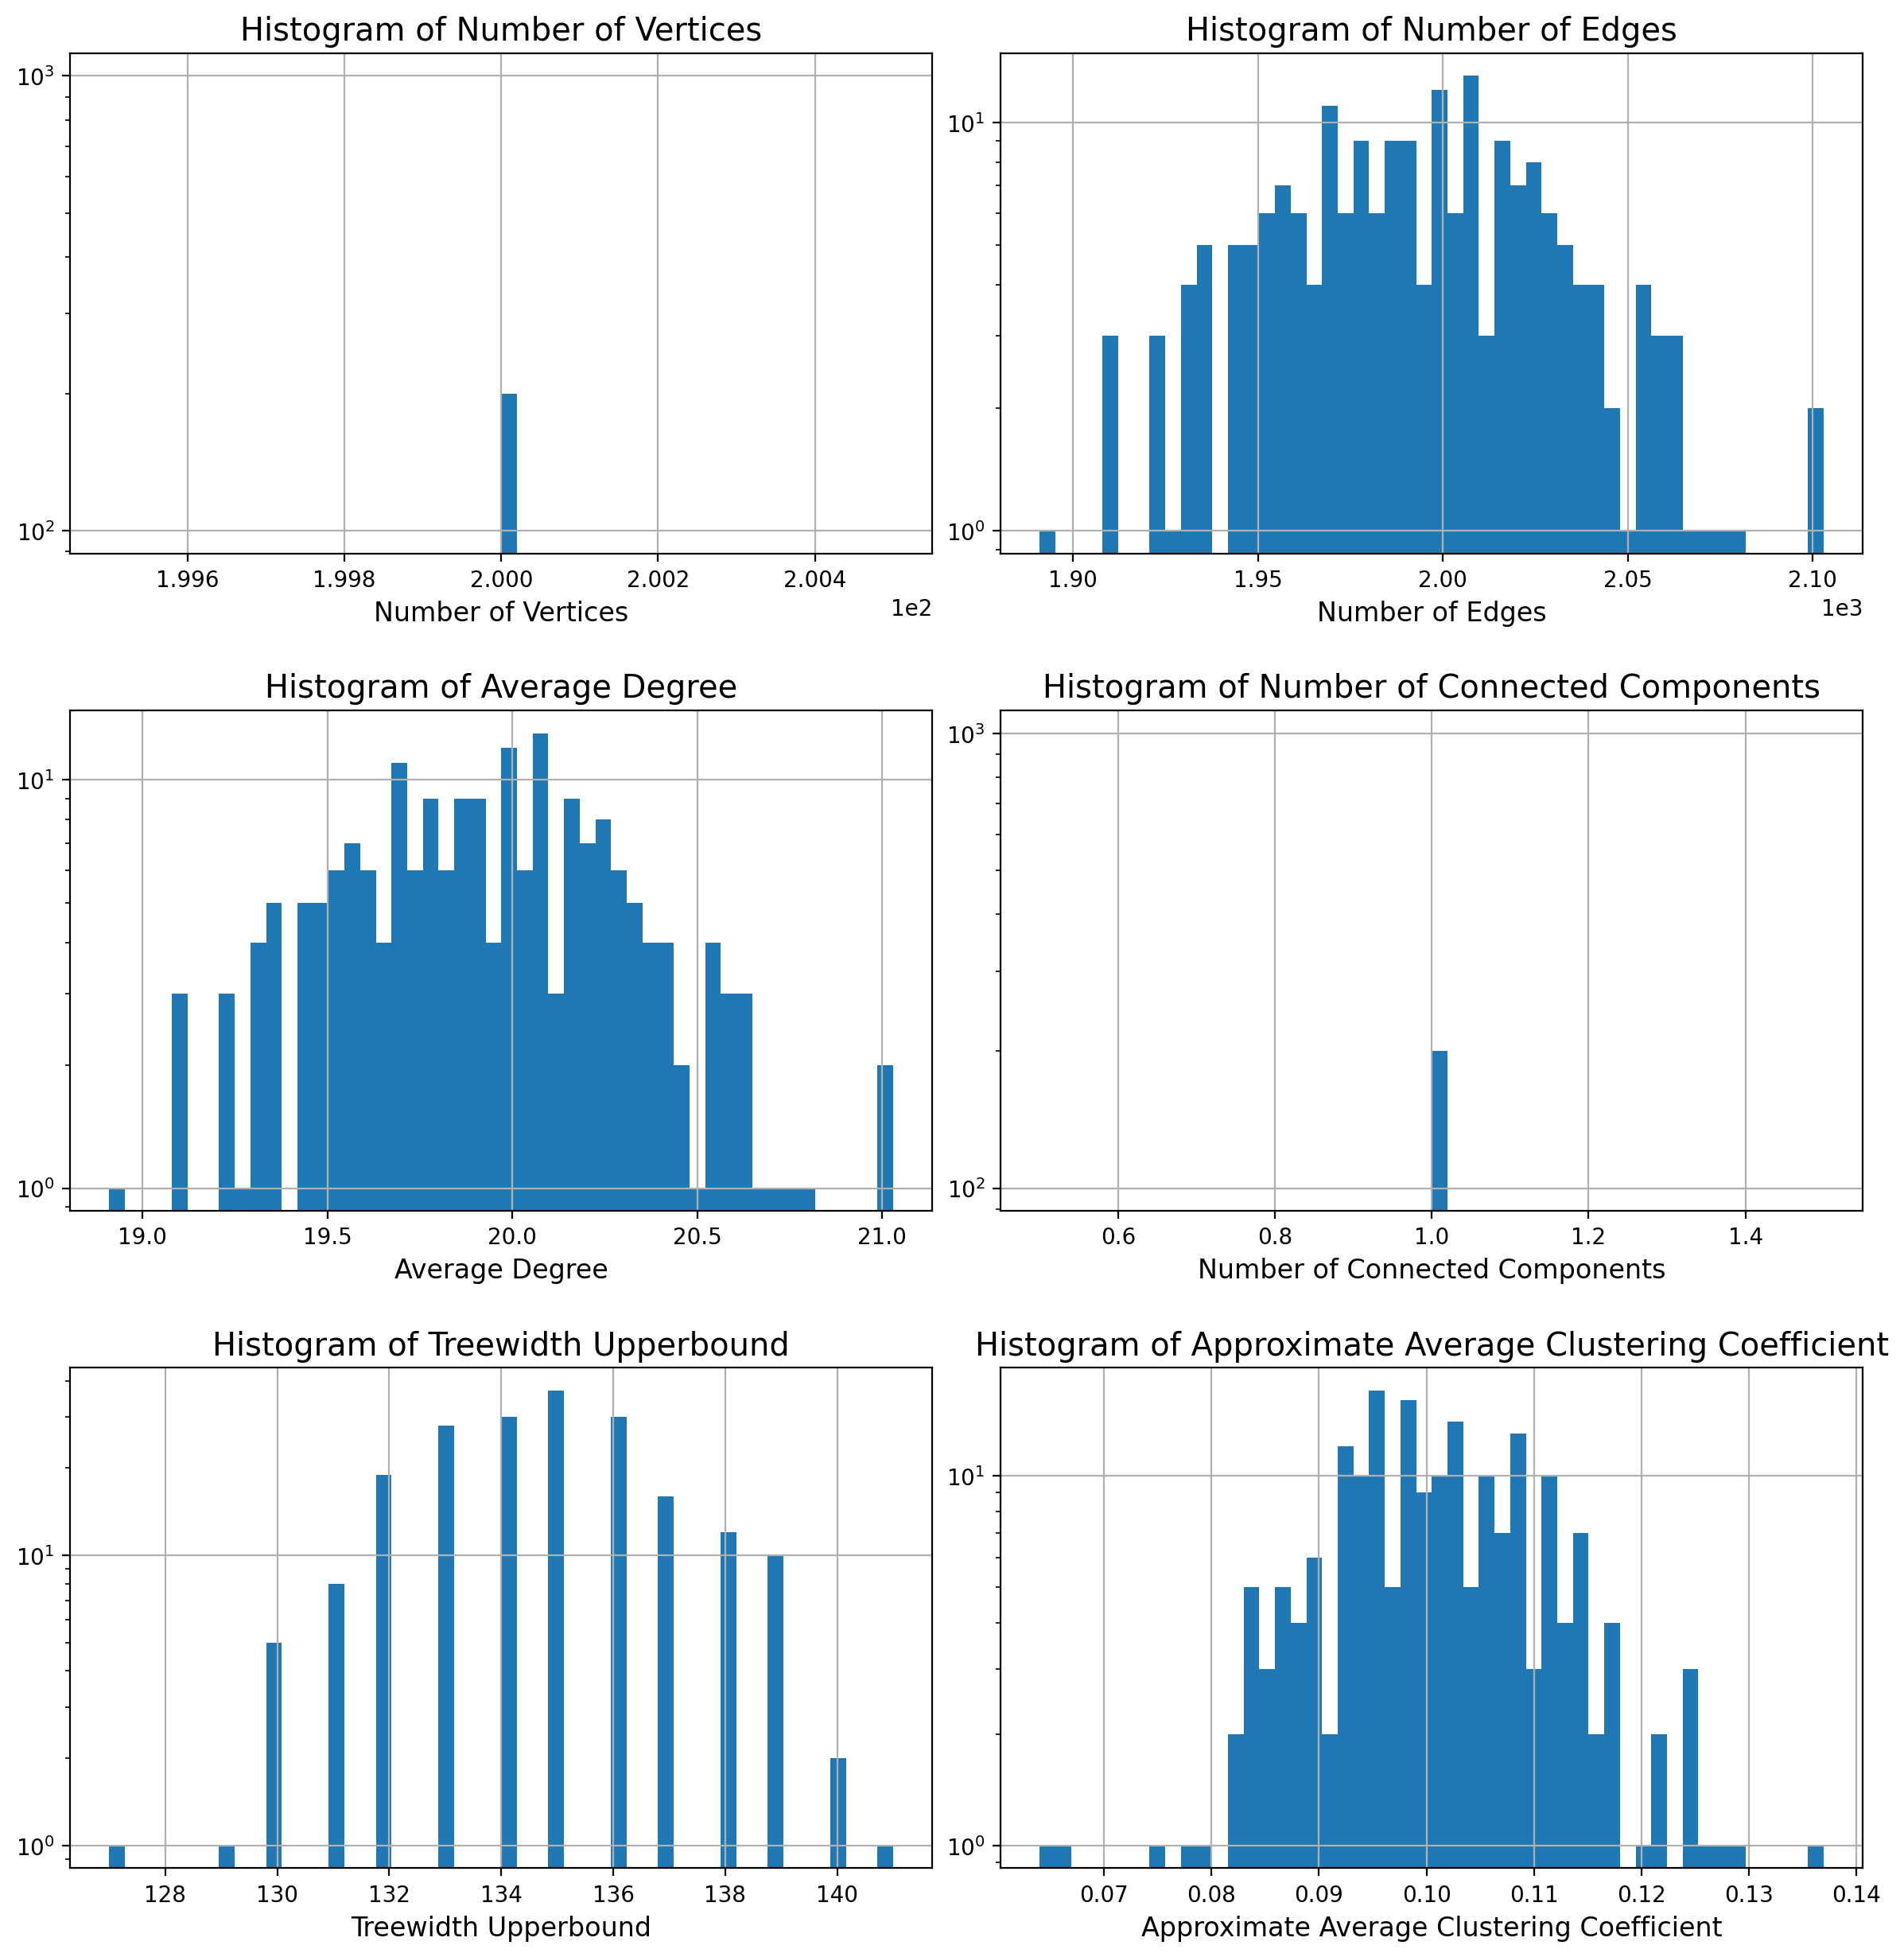

In [3]:
df_er = pd.read_csv("erdos_reyni_small.csv")

plot_graph_df(df_er)
plt.savefig("erdos_reyni_small.pdf", bbox_inches="tight")

# PACE 2019 Competition Graphs

In [11]:
rows = []

filepaths = list(yield_metis_filenames("../data/pace_unweighted/"))
# print(filepaths)
for filepath in tqdm(filepaths):
    path = filepath.resolve()
    # print(path)
    G = metis_to_nx(path)
    rows.append(pd.Series(summarize_graph(G, path.stem)))

    gc.collect()

df_pace = pd.DataFrame(rows).set_index("name")
df_pace

100%|██████████| 200/200 [54:53<00:00, 16.47s/it]   


,n_nodes,n_edges,avg_deg,n_components,n_isolates,sum_weights,treewidth_min_degree,average_clustering
name,,,,,,,,
vc-exact_001,6160,40207,13.054221,32,0,6160,131,0.697
vc-exact_002,51795,41253,1.592934,10542,0,51795,1,0.000
vc-exact_003,60541,48418,1.599511,12123,0,60541,1,0.000
vc-exact_004,8114,26013,6.411881,6,0,8114,1612,0.013
vc-exact_005,200,798,7.980000,1,0,200,85,0.051
...,...,...,...,...,...,...,...,...
vc-exact_196,1534,126082,164.383312,1,0,1534,1342,0.221
vc-exact_197,1534,127011,165.594524,1,0,1534,1336,0.207
vc-exact_198,1150,80072,139.255652,1,0,1150,1008,0.226


In [12]:
df_pace.to_csv("pace_unweighted.csv")

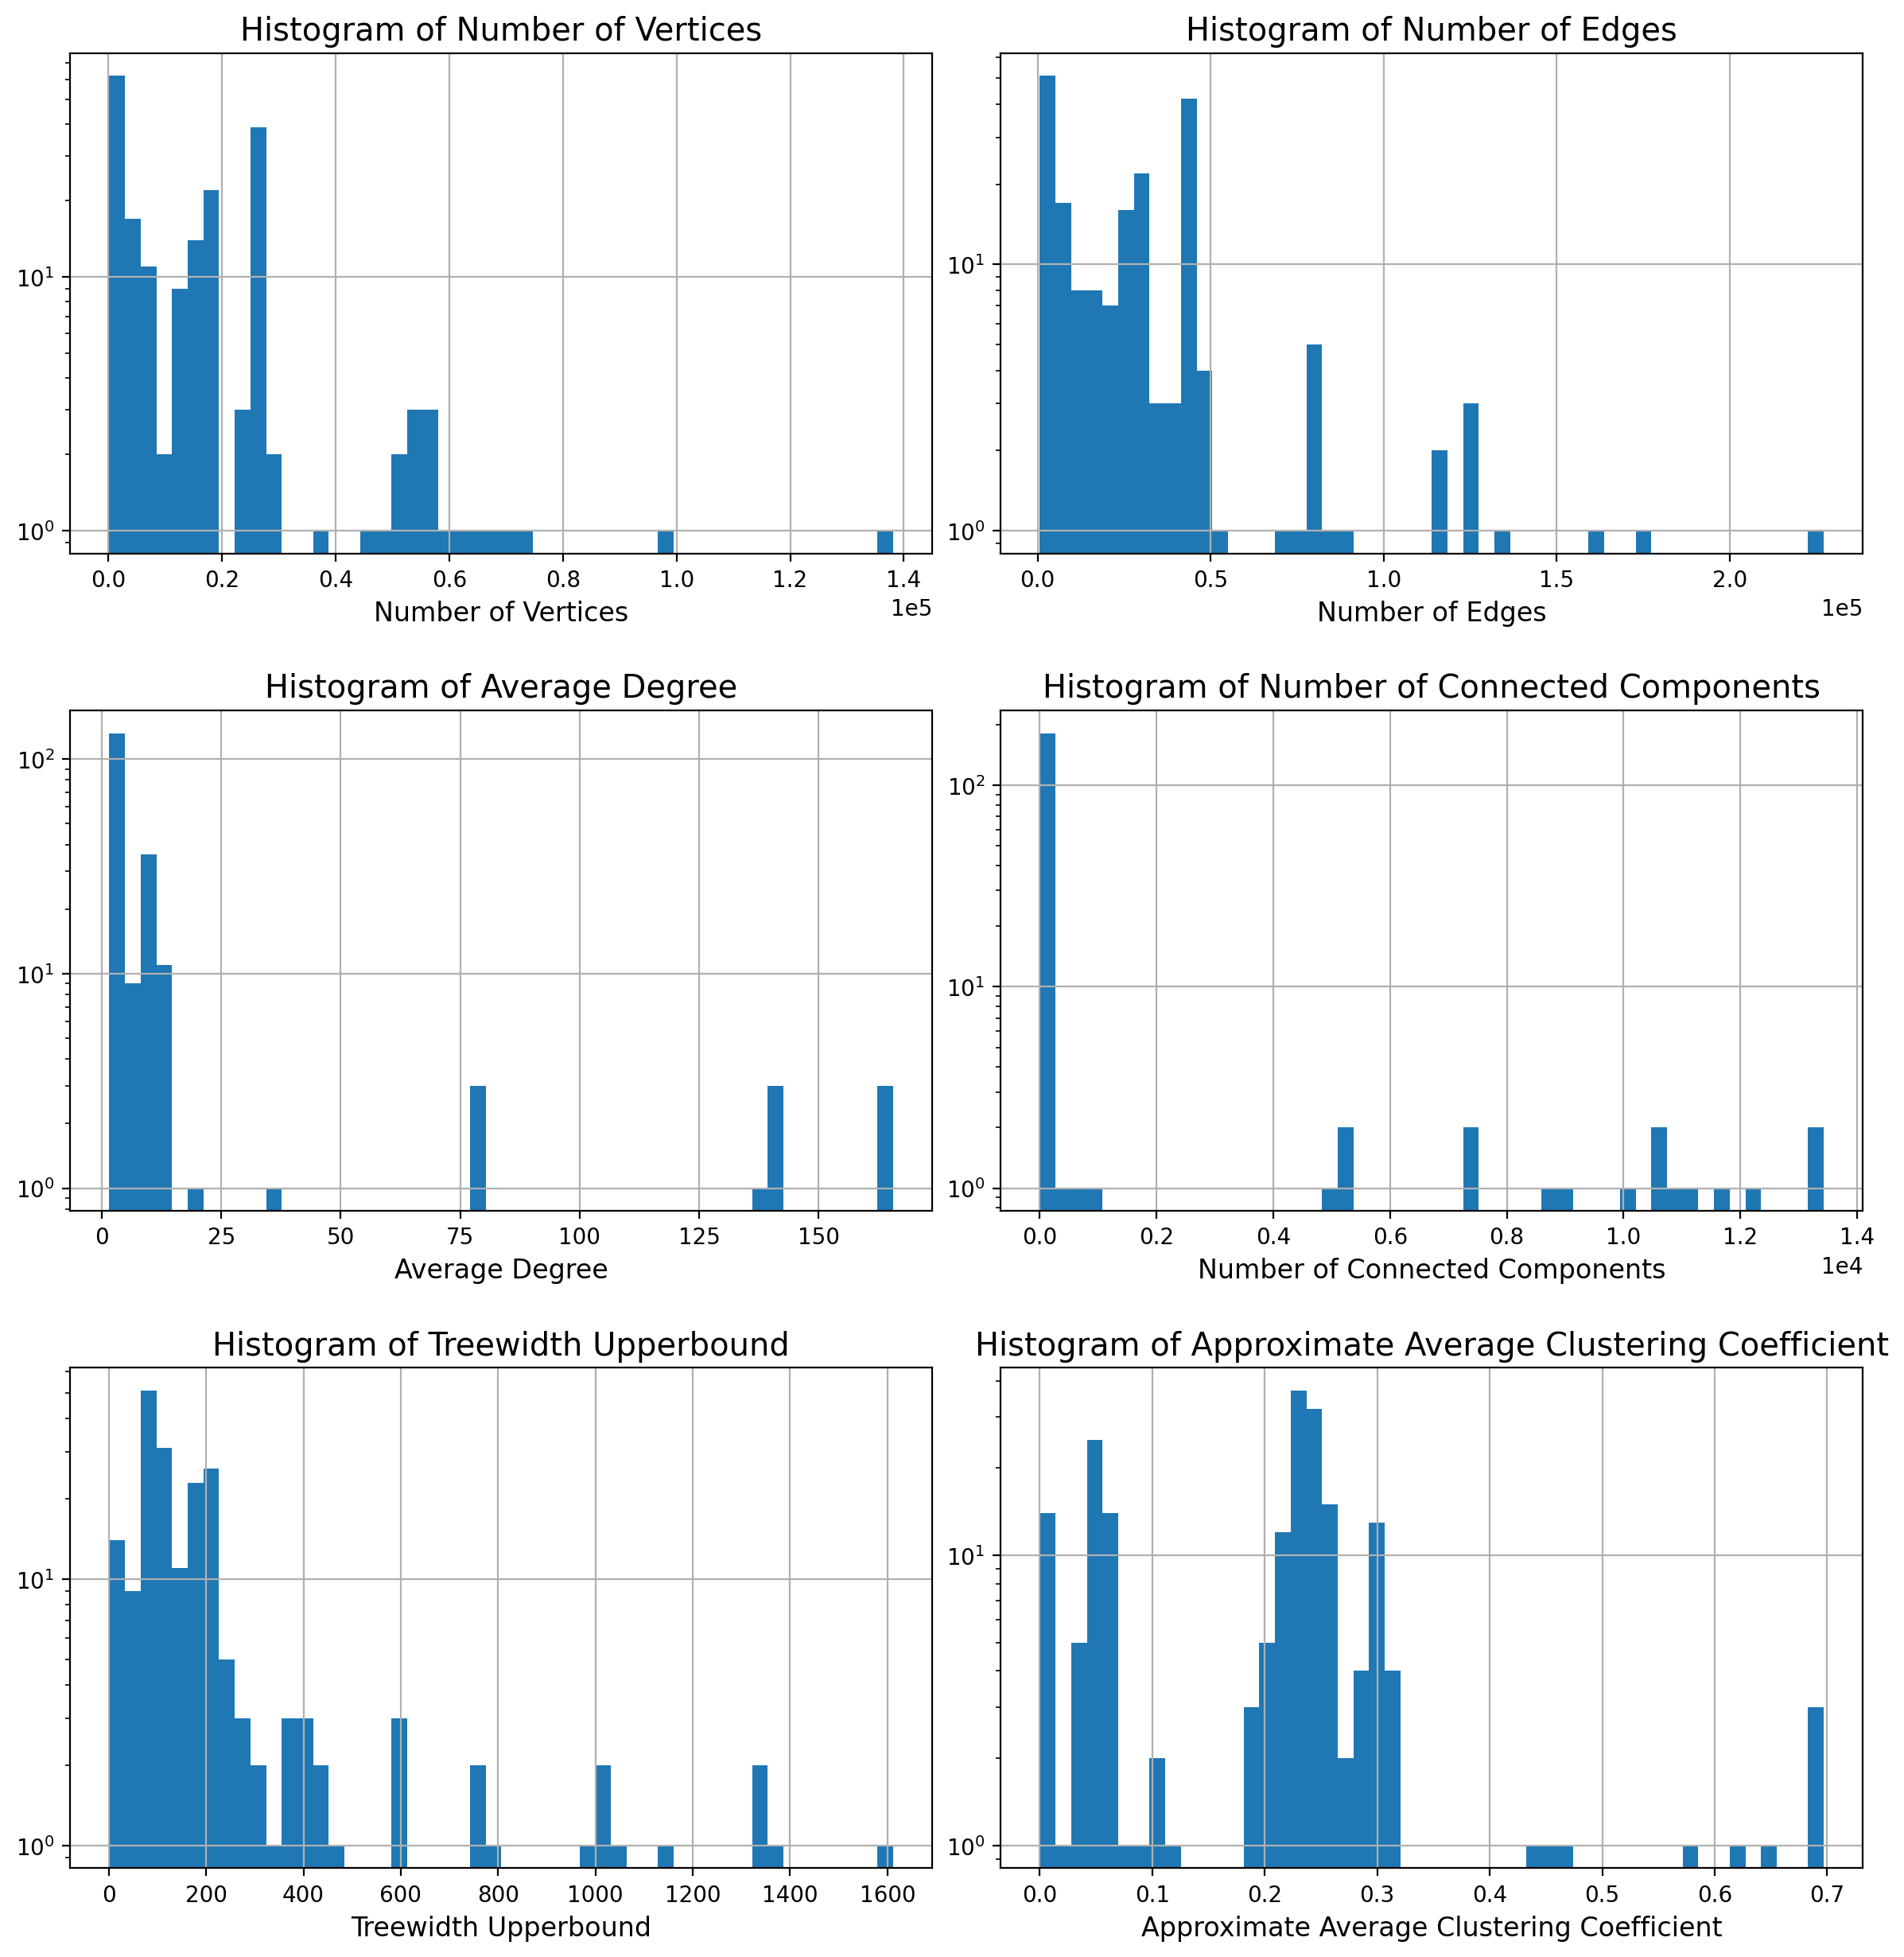

In [4]:
df_pace = pd.read_csv("pace_unweighted.csv")

plot_graph_df(df_pace)
plt.savefig("pace_unweighted.pdf", bbox_inches="tight")